In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def EMA_S(prices, period=9) : #Trading init. avec SMA
    sma = prices.rolling(window=period).mean()
    alpha = 2 / (period + 1)
    ema = [sma.iloc[period-1,0]]
    for i in range(1, len(prices)) :
        ema.append(prices.iloc[i, 0] * alpha + ema[-1] * (1 - alpha))
    return pd.DataFrame(ema, index=prices.index)

def EMA_P(prices, period=9) : #Pandas init. avec prix (1er)
    ema = prices.ewm(span=period, adjust=False).mean()
    return ema

In [79]:
def backtest_MACD(ticker, prices, period_low=12, period_high=26, period_signal=9):
    macd=pd.DataFrame()
    macd['Close'] = prices
    macd['Ema_low'] = EMA_S(prices, period_low).squeeze()
    macd['Ema_high'] = EMA_S(prices, period_high).squeeze()
    macd['MACD'] = macd['Ema_low'] - macd['Ema_high']
    macd['Ema_signal'] = EMA_S(macd['MACD'].to_frame(), period_signal).squeeze()
    macd['Histogram'] = macd['MACD'] - macd['Ema_signal']
    macd['Signal'] = np.where(macd['MACD'] > macd['Ema_signal'], 1, -1)
    macd['Change'] = macd['Signal'].diff()
    macd['Trade'] = 0
    macd['In_position'] = 0

    in_position = False
    for i in range(1, len(macd)) :
        if macd['Change'].iloc[i] == 2 :
            if not in_position :
                macd.loc[macd.index[i], 'Trade'] = 1
                in_position = True
                macd.loc[macd.index[i], 'In_position'] = 1
                
        elif macd['Change'].iloc[i] == -2 :
            if in_position :
                macd.loc[macd.index[i], 'Trade'] = -1
                in_position = False
                macd.loc[macd.index[i], 'In_position'] = -1
                
    buys = macd[macd['Trade'] == 1]
    sells = macd[macd['Trade'] == -1]
    profits = []
    n_trades = min(len(buys), len(sells))
    for k in range(n_trades) :
        buy_price = buys['Close'].iloc[k]
        sell_price = sells['Close'].iloc[k]
        profit = ((sell_price - buy_price) / buy_price) * 100
        profits.append(profit)

    #résultats
    print(f" \n Performances -- {ticker}")
    print(f"Nombre de trades passés : {n_trades}")
    print(f"Taux de réussite : {(np.array(profits) > 0).sum() / n_trades * 100 :.1f}%")
    print(f"Profit total : {np.sum(profits):.2f}%")
    print(f"Profit moyen : {np.mean(profits):.2f}%")
    print(f"Meilleur trade : {np.max(profits):.2f}%")
    print(f"Pire trade : {np.min(profits):.2f}%")

    #Illustrations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(prices.index, prices, label='Prix', color='black', linewidth=1.5)
    ax1.plot(macd.index, macd['Ema_low'], label='EMA 12', color='blue')
    ax1.plot(macd.index, macd['Ema_high'], label='EMA 26', color='red')
    ax1.set_ylabel('Prix')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Prix et Moyennes Mobiles Exponentielles')

    ax2.plot(macd.index, macd['MACD'], label='MACD', color='blue', linewidth=1.5)
    ax2.plot(macd.index, macd['Ema_signal'], label='Signal', color='red', linewidth=1.5)
    ax2.bar(macd.index, macd['Histogram'], label='Histogram', color='gray', alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('MACD')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('MACD Indicator')
    plt.tight_layout()
    plt.show()

def buy_and_hold(ticker, prices) :
    returns = prices.pct_change().mean(axis=1)
    cumulative = (1 + returns).cumprod()
    print(f"Performance Buy & Hold: {(cumulative.iloc[-1] - 1) * 100 :.2f}%")
    return cumulative

In [80]:
apple = "AAPL"
data = yf.download(apple, start="2024-10-30", end="2025-10-30", interval='1h', auto_adjust=True)
prices = data['Close']

[*********************100%***********************]  1 of 1 completed


 
 Performances -- AAPL
Nombre de trades passés : 51
Taux de réussite : 51.0%
Profit total : 42.52%
Profit moyen : 0.83%
Meilleur trade : 10.85%
Pire trade : -7.05%


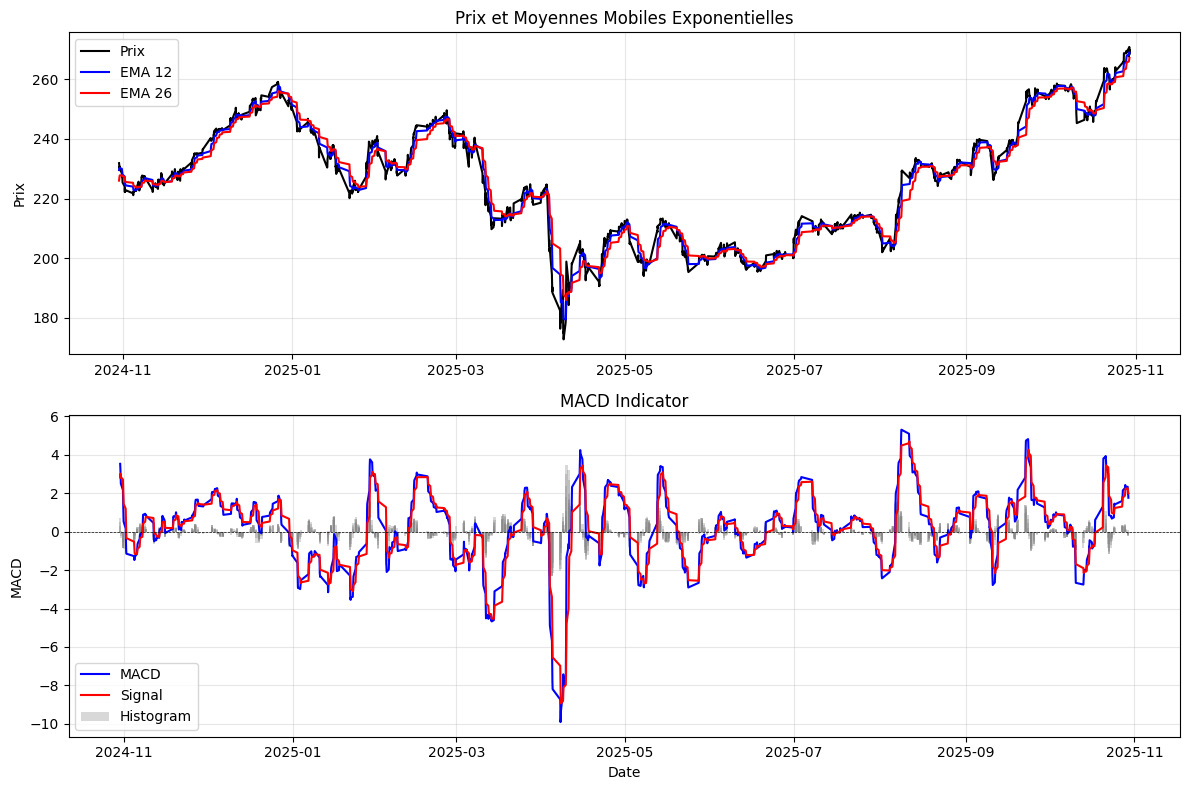

Performance Buy & Hold: 16.33%


Datetime
2024-10-30 13:30:00+00:00         NaN
2024-10-30 14:30:00+00:00    0.998685
2024-10-30 15:30:00+00:00    0.997153
2024-10-30 16:30:00+00:00    0.993018
2024-10-30 17:30:00+00:00    0.994781
                               ...   
2025-10-29 15:30:00+00:00    1.158544
2025-10-29 16:30:00+00:00    1.164194
2025-10-29 17:30:00+00:00    1.167989
2025-10-29 18:30:00+00:00    1.157207
2025-10-29 19:30:00+00:00    1.163331
Length: 1738, dtype: float64

In [81]:
backtest_MACD(apple, prices, period_low=12, period_high=26, period_signal=9)
buy_and_hold(apple, prices)